In [1]:
import numpy as np
import scipy.stats as stats
import scipy.special as special
import pandas as pd
import chaospy as cp
import pyDOE

%matplotlib inline
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns

sns.set_style("ticks")#'whitegrid')#
#sns.set_context("talk")
sns.set_style({'axes.linewidth':0.5,
               'xtick.direction': u'in',
               'xtick.major.size': 1.,
               'xtick.minor.size': 0.5,
               'ytick.direction': u'in',               
               'ytick.major.size': 1.,
               'ytick.minor.size': 0.5})  


:0: FutureWarning: IPython widgets are experimental and may change in the future.


# 4b) Multivariate with Rosemblat

Model:

$ u = I\,e^{-a\,x} $ 

In [2]:
def u(x,a,I):
    return I*np.exp(-a*x)

x = np.linspace(0,10,101)

In [3]:
dist_a = cp.Uniform(.6,.8)
dist_I = cp.Weibull(shape=2., scale=(0.3+dist_a)**4.*6., shift=0)
dist_Q = cp.J(dist_a, dist_I)
dist_R = cp.J(cp.Uniform(),cp.Uniform())

dist_train = cp.J(cp.Uniform(.6,.8),cp.Uniform(0.,20))

### a) Full MC with Halton sampling

In [4]:
sample_inputs = dist_Q.sample(size=1000,rule='H')
sample_u = np.array([u(x,*node) for node in sample_inputs.T])

E_u = np.mean(sample_u,axis=0)
Std_u = np.std(sample_u,axis=0)
Q05_u = np.percentile(sample_u,5,axis=0)
Q95_u = np.percentile(sample_u,95,axis=0)

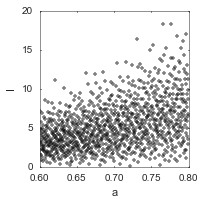

In [5]:
fig = plt.figure(figsize=[3,3])
ax = fig.add_subplot(111)
ax.plot(sample_inputs[0,:],sample_inputs[1,:],'.k',alpha=0.5)

ax.set_xlabel('a')
ax.set_ylabel('I')

fig.tight_layout()
fig.savefig('Figures/4b_Rosenblatt_MC_sample.pdf')
print

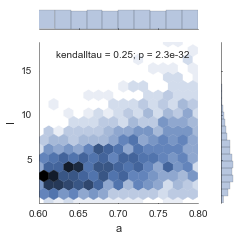

In [6]:
fig=sns.jointplot(sample_inputs[0,:],
              sample_inputs[1,:], 
              kind="hex", 
              stat_func=stats.kendalltau,
              size=3.5
             )

fig.set_axis_labels('a','I')
fig = plt.gcf()
fig.tight_layout()
fig.savefig('Figures/4_Rosenblatt_MC_sample_joint.pdf')
print


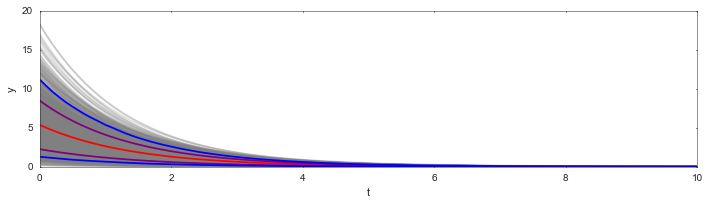

In [7]:
fig = plt.figure(figsize=[10,3])
ax = fig.add_subplot(111)

ax.plot(x,sample_u.T,'grey',alpha=0.25)
ax.plot(x,E_u,'r')
ax.plot(x,E_u+Std_u,'purple')
ax.plot(x,E_u-Std_u,'purple')
ax.plot(x,Q05_u,'blue')
ax.plot(x,Q95_u,'blue')

ax.set_xlabel('t')
ax.set_ylabel('y')

fig.tight_layout()
fig.savefig('Figures/4_Rosenblatt_MC.pdf')
print

### b) Point collocation: Least squares

In [8]:
D = 2     # Number of dimensions
M = 3     # Order of the polynomial
N = M + 1 # Number of terms

In [11]:
P = cp.orth_ttr(M,dist_train)
# Exponenial rule
nodes_Q = dist_train.sample(3*special.comb(D+M+1,M+1),rule='M') #2**M-1
sample_u_pc = [u(x,*node) for node in nodes_Q.T]
u_hat = cp.fit_regression(P, nodes_Q, sample_u_pc)

45


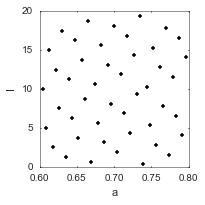

In [12]:
fig = plt.figure(figsize=[3,3])
ax = fig.add_subplot(111)

plt.plot(nodes_Q[0,:],nodes_Q[1,:],'.k')

ax.set_xlabel('a')
ax.set_ylabel('I')

fig.tight_layout()
#fig.savefig('Figures/4b_Rosenblatt_PCE_sample.pdf')
print len(nodes_Q[0,:])

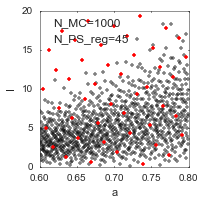

In [13]:
fig = plt.figure(figsize=[3,3])
ax = fig.add_subplot(111)
ax.plot(sample_inputs[0,:],sample_inputs[1,:],'.k',alpha=0.5)
plt.plot(nodes_Q[0,:],nodes_Q[1,:],'.r')
ax.set_xlabel('a')
ax.set_ylabel('I')

ax.text(0.62,18,'N_MC='+str(len(sample_inputs[0,:])))
ax.text(0.62,16,'N_PS_reg='+str(len(nodes_Q[0,:])))

fig.tight_layout()
fig.savefig('Figures/4b_Rosenblatt_MC_sample.pdf')
print

In [14]:
#mean_u_pc, std_u_pc = cp.E(u_hat, dist_Q), cp.Std(u_hat, dist_Q)
# Repeat the MC sample ussing the surrogate model
sample_tr_inputs = dist_Q.sample(size=1000,rule='H')
sample_u_hat = np.array([u_hat(*in_vars) for in_vars in sample_tr_inputs.T ])

mean_u_pc = np.mean(sample_u,axis=0)
std_u_pc = np.std(sample_u,axis=0)

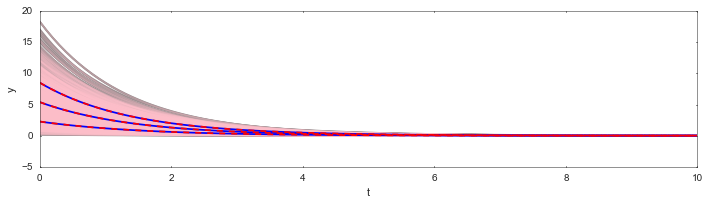

In [15]:
fig = plt.figure(figsize=[10,3])
ax = fig.add_subplot(111)

ax.plot(x,sample_u.T,'grey')
ax.plot(x,sample_u_hat.T,'pink',alpha=0.25)

ax.plot(x,E_u,'blue')
ax.plot(x,E_u+Std_u,'blue')
ax.plot(x,E_u-Std_u,'blue')

ax.plot(x,mean_u_pc,'--r')
ax.plot(x,mean_u_pc+std_u_pc,'--r')
ax.plot(x,mean_u_pc-std_u_pc,'--r')

#ax.set_yscale('log')
ax.set_xlabel('t')
ax.set_ylabel('y')

fig.tight_layout()
fig.savefig('Figures/4b_Rosenblatt_top.pdf')
print

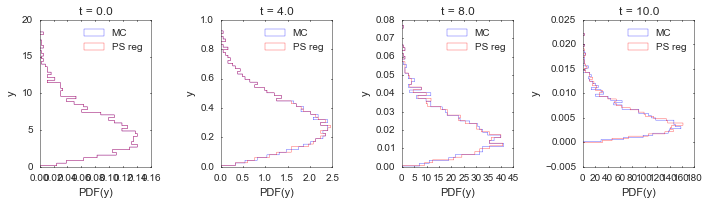

In [16]:
fig = plt.figure(figsize=[10,3])

for i,x_ref in enumerate([0., 4., 8., 10.]):
    ax = fig.add_subplot(1,4,i+1)
    ax.hist(sample_u[:,np.where(x==x_ref)[0]],
             bins=50,#np.linspace(-0.2,.2,50),
             histtype='step',
             color='blue',
             normed=True,
             cumulative=False,
             label='MC',
             orientation=u'horizontal',
            )

    ax.hist(sample_u_hat[:,np.where(x==x_ref)[0]],
             bins=50,#np.linspace(-0.2,.2,50),
             histtype='step',
             color='red',
             normed=True,
             cumulative=False,
             label='PS reg',
             orientation=u'horizontal',
            )

    ax.set_ylabel('y')
    ax.set_xlabel('PDF(y)')
    ax.set_title('t = '+str(x_ref))
    ax.legend(loc='upper right')
fig.tight_layout()
fig.savefig('Figures/4b_Rosenblatt_bot.pdf')
print

### c) PCE with Semi-spectral projection

25


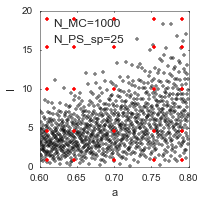

In [17]:
M = 3
P = cp.orth_ttr(M,dist_train)
nodes, weights = cp.generate_quadrature(M+1, dist_train, rule='G')

sample_u_train = [u(x,*node) for node in nodes.T]
u_hat = cp.fit_quadrature(P, nodes, weights, sample_u_train)


fig = plt.figure(figsize=[3,3])
ax = fig.add_subplot(111)
ax.plot(sample_inputs[0,:],sample_inputs[1,:],'.k',alpha=0.5)
ax.plot(nodes[0,:],nodes[1,:],'.r')
ax.set_xlabel('a')
ax.set_ylabel('I')

ax.text(0.62,18,'N_MC='+str(len(sample_inputs[0,:])))
ax.text(0.62,16,'N_PS_sp='+str(len(nodes[0,:])))

fig.tight_layout()
fig.savefig('Figures/4b_MultiNormal_MC_sample_sp.pdf')
print len(weights)

In [18]:
# Repeat the MC sample ussing the surrogate model
sample_tr_inputs = dist_Q.sample(size=1000,rule='H')
sample_u_hat = np.array([u_hat(*in_vars) for in_vars in sample_tr_inputs.T ])

# Compute the statistics from the MC
mean_u_pc = np.mean(sample_u_hat,axis=0)
std_u_pc = np.std(sample_u_hat,axis=0)

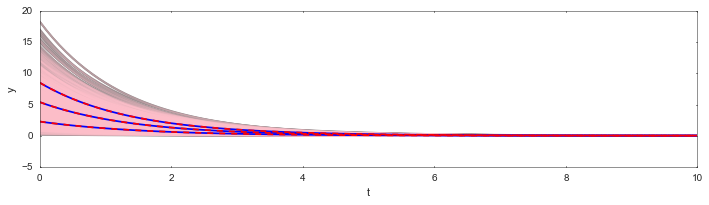

In [19]:
fig = plt.figure(figsize=[10,3])
ax = fig.add_subplot(111)

ax.plot(x,sample_u.T,'grey')
ax.plot(x,sample_u_hat.T,'pink',alpha=0.25)

ax.plot(x,E_u,'blue')
ax.plot(x,E_u+Std_u,'blue')
ax.plot(x,E_u-Std_u,'blue')

ax.plot(x,mean_u_pc,'--r')
ax.plot(x,mean_u_pc+std_u_pc,'--r')
ax.plot(x,mean_u_pc-std_u_pc,'--r')

ax.set_xlabel('t')
ax.set_ylabel('y')

fig.tight_layout()

print

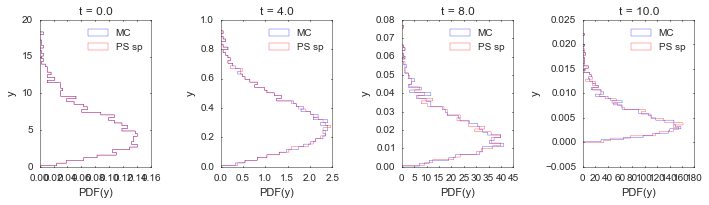

In [20]:
fig = plt.figure(figsize=[10,3])

for i,x_ref in enumerate([0., 4., 8., 10.]):
    ax = fig.add_subplot(1,4,i+1)
    ax.hist(sample_u[:,np.where(x==x_ref)[0]],
             bins=50,#np.linspace(-0.2,.2,50),
             histtype='step',
             color='blue',
             normed=True,
             cumulative=False,
             label='MC',
             orientation=u'horizontal',
            )

    ax.hist(sample_u_hat[:,np.where(x==x_ref)[0]],
             bins=50,#np.linspace(-0.2,.2,50),
             histtype='step',
             color='red',
             normed=True,
             cumulative=False,
             label='PS sp',
             orientation=u'horizontal',
            )

    ax.set_ylabel('y')
    ax.set_xlabel('PDF(y)')
    ax.set_title('t = '+str(x_ref))
    ax.legend(loc='upper right')
fig.tight_layout()
fig.savefig('Figures/4b_Rosenblatt_bot_sp.pdf')
print

### e) Convergence

In [21]:
class Saltelli_correlated:

    def __init__(self, dist, dist_Q, samples, poly=None, rule="R"):
        self.dist = dist
        self.dist_Q = dist_Q
        samples_ = dist.sample(2*samples, rule=rule)
        self.samples1 = samples_.T[:samples].T
        self.samples2 = samples_.T[samples:].T
        self.poly = poly

    def __getitem__(self, indices):
        assert len(self.dist) == len(indices)

        key = "".join([i and "a" or "b" for i in indices])

        if hasattr(self, key):
            return getattr(self, key)

        new = np.empty(self.samples1.shape)
        for i in xrange(len(indices)):
            if indices[i]:
                new[i] = self.samples1[i]
            else:
                new[i] = self.samples2[i]

        if self.poly:
            new = self.poly(*self.dist_Q.inv(self.dist.fwd(new)))

        setattr(self, key, new)
        return new

In [22]:
dim = len(dist_Q)
Y = Saltelli_correlated(dist=dist_R, dist_Q=dist_Q, samples=1e3, poly=u_hat, rule='L')

zeros = [0]*dim #Y[zeros]=B
ones  = [1]*dim #Y[ones]=A
index = [1]*dim 

V = np.var(Y[zeros], -1)

out = []
out_m = []
out_sum = []
for d in xrange(dim):

    index[d] = 0 
    s = 1 - np.mean((Y[zeros]-Y[index])**2, -1) / (2.*V+(V==0))*(V!=0)
    #s = 1 - np.mean((Y[ones]-Y[index])**2, -1) / (2*V+(V==0))*(V!=0)
    
    #s_m = np.mean((Y[ones]-Y[index])**2, -1) / (2.*V+(V==0))*(V!=0)
    s_m = np.mean((Y[zeros]-Y[index])**2, -1) / (2*V+(V==0))*(V!=0)
    
    out.append(s)
    out_m.append(s_m)
    out_sum.append(s+s_m)
    index[d] = 1

Sensitivity = np.array(out)
Sensitivity_m = np.array(out_m)
Sensitivity_sum = np.array(out_sum)

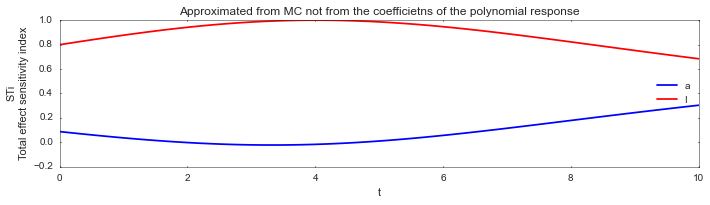

In [24]:
#Sensitivity = cp.Sens_t_sample(u_hat, dist_Q, samples=1e1, rule='L')
#Sensitivity = cp.Sens_t(u_hat, dist_train)

fig = plt.figure(figsize=[10,3])
ax = fig.add_subplot(111)
ax.plot(x,Sensitivity[0,:],'blue',label='a')
ax.plot(x,Sensitivity[1,:],'red',label='I')
ax.legend(loc='center right')

ax.set_xlabel('t')
ax.set_ylabel('STi\nTotal effect sensitivity index')

ax.set_title('Approximated from MC not from the coefficietns of the polynomial response')

fig.tight_layout()
fig.savefig('Figures/4b_Rosenblatt_Sens.pdf')



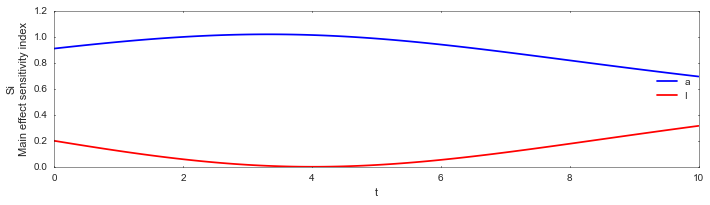

In [25]:
#Sensitivity_m = cp.Sens_m_sample(u_hat, dist_Q, samples=1e6, rule='L')

fig = plt.figure(figsize=[10,3])
ax = fig.add_subplot(111)
ax.plot(x,Sensitivity_m[0,:],'blue',label='a')
ax.plot(x,Sensitivity_m[1,:],'red',label='I')
ax.legend(loc='center right')

ax.set_xlabel('t')
ax.set_ylabel('Si\nMain effect sensitivity index')

fig.tight_layout()
fig.savefig('Figures/4b_Rosenblatt_Sens_m.pdf')

### Convergence

In [26]:
#```python
sample_inputs = dist_Q.sample(size=(10**6))
sample_u = np.array([u(x,*node) for node in sample_inputs.T])

E_u = np.mean(sample_u,axis=0)
Std_u = np.std(sample_u,axis=0)
#```

In [27]:
def PCE(M):
    # M: Order of the polynomial
    D = 2    # Number of dimensions

    P = cp.orth_ttr(M,dist_train)
    # Hammersley sampling proved to be optimally stable [Hosder]=ref(at)Chaospy[31]
    Npc = int(3*special.comb(D+M+1,M+1)) 
    
    print Npc
    
    nodes_Q = dist_train.sample(Npc,rule='M') 
    sample_u_pc = np.array([u(x,*node) for node in nodes_Q.T])

    u_hat = cp.fit_regression(P=P, x=nodes_Q, u=sample_u_pc)  

    sample_u_hat = np.array([u_hat(*in_vars) for in_vars in sample_inputs.T ])

    mean_u_pc = np.mean(sample_u_hat,axis=0)
    std_u_pc = np.std(sample_u_hat,axis=0)
    
    Error_E = np.trapz(np.abs(E_u - mean_u_pc)/E_u,x)/10.
    Error_Std = np.trapz(np.abs(std_u_pc**2./Std_u**2. - 1.),x)/10.  
    
    return Npc,Error_E, Error_Std

In [28]:
order = range(2,8)
Npc     = np.zeros(len(order))
Error_E = np.zeros(len(order))
Error_Std = np.zeros(len(order))

for i,M in enumerate(order):
    Npc[i],Error_E[i], Error_Std[i] = PCE(M)

30
45
63
84
108
135


In [29]:
def PCE_sp(M):
    # M: Order of the polynomial
    D = 2    # Number of dimensions

    P = cp.orth_ttr(M,dist_train)
    nodes, weights = cp.generate_quadrature(M+1, dist_train, rule='G')
    
    Npc = len(weights)
    
    sample_u_train = [u(x,*node) for node in nodes.T]
    u_hat = cp.fit_quadrature(P, nodes, weights, sample_u_train)

    sample_u_hat = np.array([u_hat(*in_vars) for in_vars in sample_inputs.T ])

    mean_u_pc = np.mean(sample_u_hat,axis=0)
    std_u_pc = np.std(sample_u_hat,axis=0)
    
    Error_E = np.trapz(np.abs(E_u - mean_u_pc)/E_u,x)/10.
    Error_Std = np.trapz(np.abs(std_u_pc**2./Std_u**2. - 1.),x)/10.  
    
    return Npc,Error_E, Error_Std

In [30]:
order   = range(2,8)
Npc_sp     = np.zeros(len(order))
Error_E_sp = np.zeros(len(order))
Error_Std_sp = np.zeros(len(order))

for i,M in enumerate(order):
    Npc_sp[i],Error_E_sp[i], Error_Std_sp[i] = PCE_sp(M)

In [31]:
def MC(Nmc):
    sample_inputs = dist_Q.sample(size=Nmc,rule='M')
    sample_u = np.array([u(x,*node) for node in sample_inputs.T])

    E_u_mc = np.mean(sample_u,axis=0)
    Std_u_mc = np.std(sample_u,axis=0)
    
    Error_E_mc = np.trapz(np.abs(E_u - E_u_mc)/E_u,x)/10.
    Error_Std_mc = np.trapz(np.abs(Std_u_mc**2./Std_u**2.-1.),x)/10.
    
    return Error_E_mc, Error_Std_mc

In [32]:
Nmc     = [10,10**2,10**3,10**4,10**5]
Error_E_mc = np.zeros(len(Nmc))
Error_Std_mc = np.zeros(len(Nmc))

for i,N in enumerate(Nmc):
    Error_E_mc[i], Error_Std_mc[i] = MC(N)

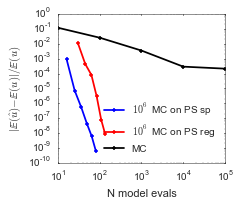

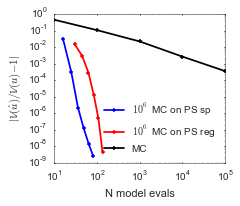

In [33]:
output_name_label = 'u'

fig = plt.figure(figsize=[3.5,3])
ax = fig.add_subplot(111)
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_ylim([1e-6,1e0])
ax.plot(Npc_sp,Error_E_sp,'.-b',label='$10^6$ MC on PS sp')
ax.plot(Npc,Error_E,'.-r',label='$10^6$ MC on PS reg')
ax.plot(Nmc,Error_E_mc,'.-k',label='MC')
ax.set_xlabel('N model evals')
ax.set_ylabel(r'$|\mathbb{E}(\hat{'+output_name_label+'})-\mathbb{E}('+output_name_label+')|/\mathbb{E}('+output_name_label+')$')
ax.legend(loc='lower right')
fig.tight_layout()
fig.savefig('Figures/4b_Convergence_E_'+output_name_label+'.pdf')


fig = plt.figure(figsize=[3.5,3])
ax = fig.add_subplot(111)
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_ylim([1e-4,1e0])
ax.plot(Npc_sp,Error_Std_sp,'.-b',label='$10^6$ MC on PS sp')
ax.plot(Npc,Error_Std,'.-r',label='$10^6$ MC on PS reg')
ax.plot(Nmc,Error_Std_mc,'.-k',label='MC')
ax.set_xlabel('N model evals')
ax.set_ylabel(r'$|\mathbb{V}(\hat{'+output_name_label+'})/\mathbb{V}('+output_name_label+') -1|$')
ax.legend(loc='lower right')
fig.tight_layout()
fig.savefig('Figures/4b_Convergence_V_'+output_name_label+'.pdf')